# Data Preparation

In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models


In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [94]:
# Where you want the dataset stored
data_dir = "./data"
train_ratio = 0.9   # 90% train, 10% validation


# Simple transform (you can change later)
transform = transforms.Compose([
    transforms.ToTensor()
])

# This will:
# - CHECK if CIFAR-10 exists in data_dir
# - DOWNLOAD it if missing
train_dataset = datasets.CIFAR10(
    root=data_dir,
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.CIFAR10(
    root=data_dir,
    train=False,
    transform=transform,
    download=True
)


In [95]:
from torch.utils.data import random_split

num_train = len(train_dataset)
num_val = int((1 - train_ratio) * num_train)
num_train = num_train - num_val

train_dataset, val_dataset = random_split(
    train_dataset,
    [num_train, num_val],
    generator=torch.Generator().manual_seed(42)  # reproducible split
)

print("CIFAR-10 ready!")

CIFAR-10 ready!


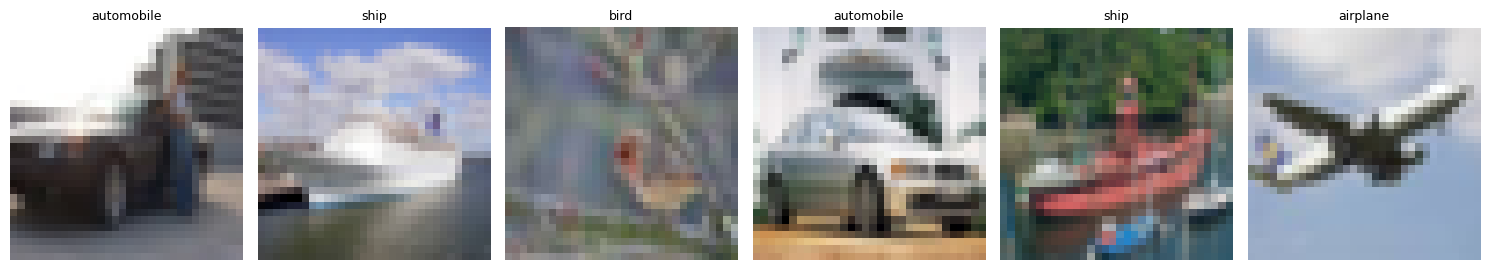

In [96]:


import random
import matplotlib.pyplot as plt

num_samples = 6
indices = random.sample(range(len(train_dataset)), num_samples)

plt.figure(figsize=(15, 3))

for i, idx in enumerate(indices):
    image, label = train_dataset[idx]

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(train_dataset.dataset.classes[label], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [97]:
type(image)  # Should be torch.Tensor
print(image.shape)  # Should be torch.Size([3, 32, 32])

torch.Size([3, 32, 32])


# Baseline Training

In [98]:
batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)
print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Test samples:", len(test_dataset))


Train samples: 45001
Validation samples: 4999
Test samples: 10000


In [99]:
model = models.resnet18(pretrained=False)


# Modify first layer for CIFAR
model.conv1 = nn.Conv2d(
    3, 64, kernel_size=3, stride=1, padding=1, bias=False
)

# Modify classifier
model.fc = nn.Linear(model.fc.in_features, 10)

model = model.to(device)


In [100]:
print(model.fc.in_features)

512


In [101]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [102]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    return running_loss / len(loader), acc


In [103]:
def evaluate(model, loader, criterion):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    return loss / len(loader), acc


In [104]:
import os

# Training settings
num_epochs = 50

# Where to save best model
save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "resnet18_cifar10.pth")

# EarlyStopping utility: stops training when validation loss stops improving
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.0, path=None, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.verbose = verbose
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model=None):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.path is not None and model is not None:
                torch.save(model.state_dict(), self.path)
                if self.verbose:
                    print(f"Validation loss decreased. Saving model to {self.path}")
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# Tracking lists
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Instantiate early stopper (will save best model to model_path)
early_stopper = EarlyStopping(patience=7, path=model_path, min_delta=0.001, verbose=True)


In [ ]:
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion
    )
    val_loss, val_acc = evaluate(
        model, val_loader, criterion
    )

    # Store values
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
    print(f"  Val  Acc: {val_acc:.4f}, Val  Loss: {val_loss:.4f}")

    # Early stopping: checks validation loss and saves best model via EarlyStopping
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        # torch.save(model.state_dict(), early_stopper.path)
        print(f"Early stopping triggered. Stopping training")
        break


Epoch [1/50]
  Train Acc: 56.9098, Train Loss: 1.2010
  Val  Acc: 63.7728, Val  Loss: 1.0494
Validation loss decreased. Saving model to ./checkpoints/resnet18_cifar10.pth
Epoch [2/50]
  Train Acc: 73.1539, Train Loss: 0.7662
  Val  Acc: 62.6525, Val  Loss: 1.1187
EarlyStopping counter: 1 out of 7
Epoch [3/50]
  Train Acc: 79.7560, Train Loss: 0.5760
  Val  Acc: 74.4149, Val  Loss: 0.7006
Validation loss decreased. Saving model to ./checkpoints/resnet18_cifar10.pth
Epoch [4/50]
  Train Acc: 84.5137, Train Loss: 0.4503
  Val  Acc: 75.4751, Val  Loss: 0.7296
EarlyStopping counter: 1 out of 7
Epoch [5/50]
  Train Acc: 87.9536, Train Loss: 0.3403
  Val  Acc: 77.6555, Val  Loss: 0.6749
Validation loss decreased. Saving model to ./checkpoints/resnet18_cifar10.pth
Epoch [6/50]
  Train Acc: 91.5891, Train Loss: 0.2437
  Val  Acc: 79.8960, Val  Loss: 0.6562
Validation loss decreased. Saving model to ./checkpoints/resnet18_cifar10.pth
Epoch [7/50]
  Train Acc: 93.5957, Train Loss: 0.1811
  Val  A

# Baseline Evaluation

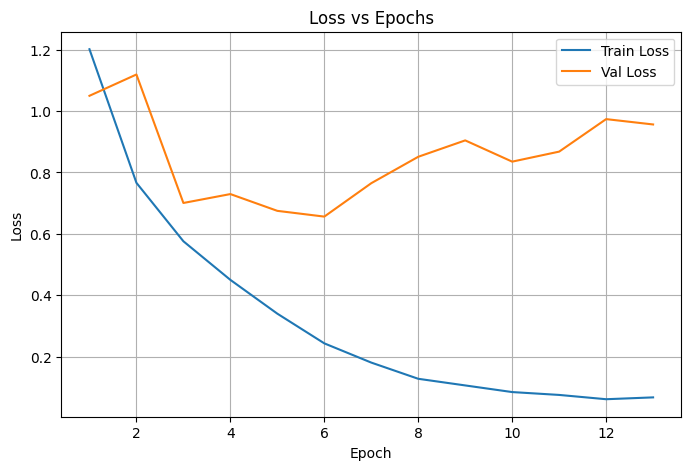

In [106]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()


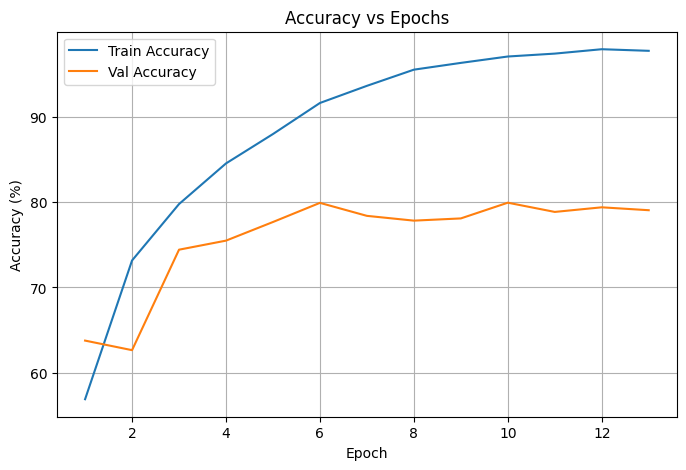

In [107]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [108]:
import torch
import os

save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "resnet18_cifar10.pth")

In [109]:
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to ./checkpoints/resnet18_cifar10.pth


In [110]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [111]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [112]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [113]:
import torch
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Convert lists → numpy arrays
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)


In [114]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="macro")
recall = recall_score(all_labels, all_preds, average="macro")
f1 = f1_score(all_labels, all_preds, average="macro")

print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")


Accuracy  : 0.7913
Precision : 0.7952
Recall    : 0.7913
F1-score  : 0.7873


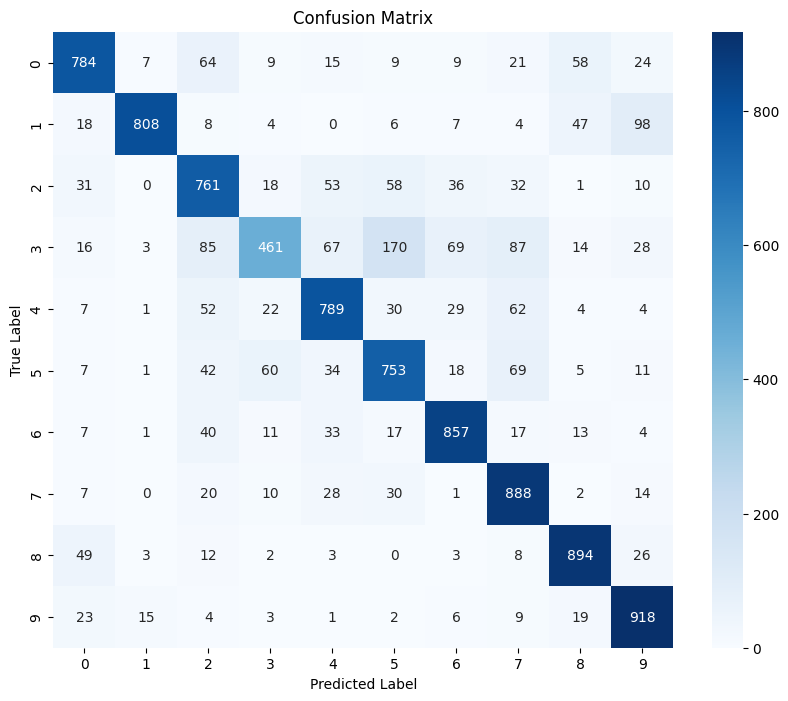

In [115]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


## Failure cases

In [116]:
from torchvision import datasets, transforms

raw_test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=False,
    transform=transforms.ToTensor()  # 🚨 NO Normalize
)


/home/wizard/deep_learning_ws/my_env/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [121]:
import torch
import torch.nn.functional as F

model.eval()

failed_cases = []  # (confidence, dataset_index, true_label, pred_label)

idx_offset = 0  # keeps track of dataset index

with torch.no_grad():
    for images, labels in test_loader:
        batch_size = images.size(0)

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        confs, preds = probs.max(dim=1)

        for i in range(batch_size):
            if preds[i] != labels[i]:
                failed_cases.append((
                    confs[i].item(),
                    idx_offset + i,   # 🔑 index into raw_test_dataset
                    labels[i].item(),
                    preds[i].item()
                ))

        idx_offset += batch_size


In [123]:
failed_cases.sort(key=lambda x: x[0], reverse=True)


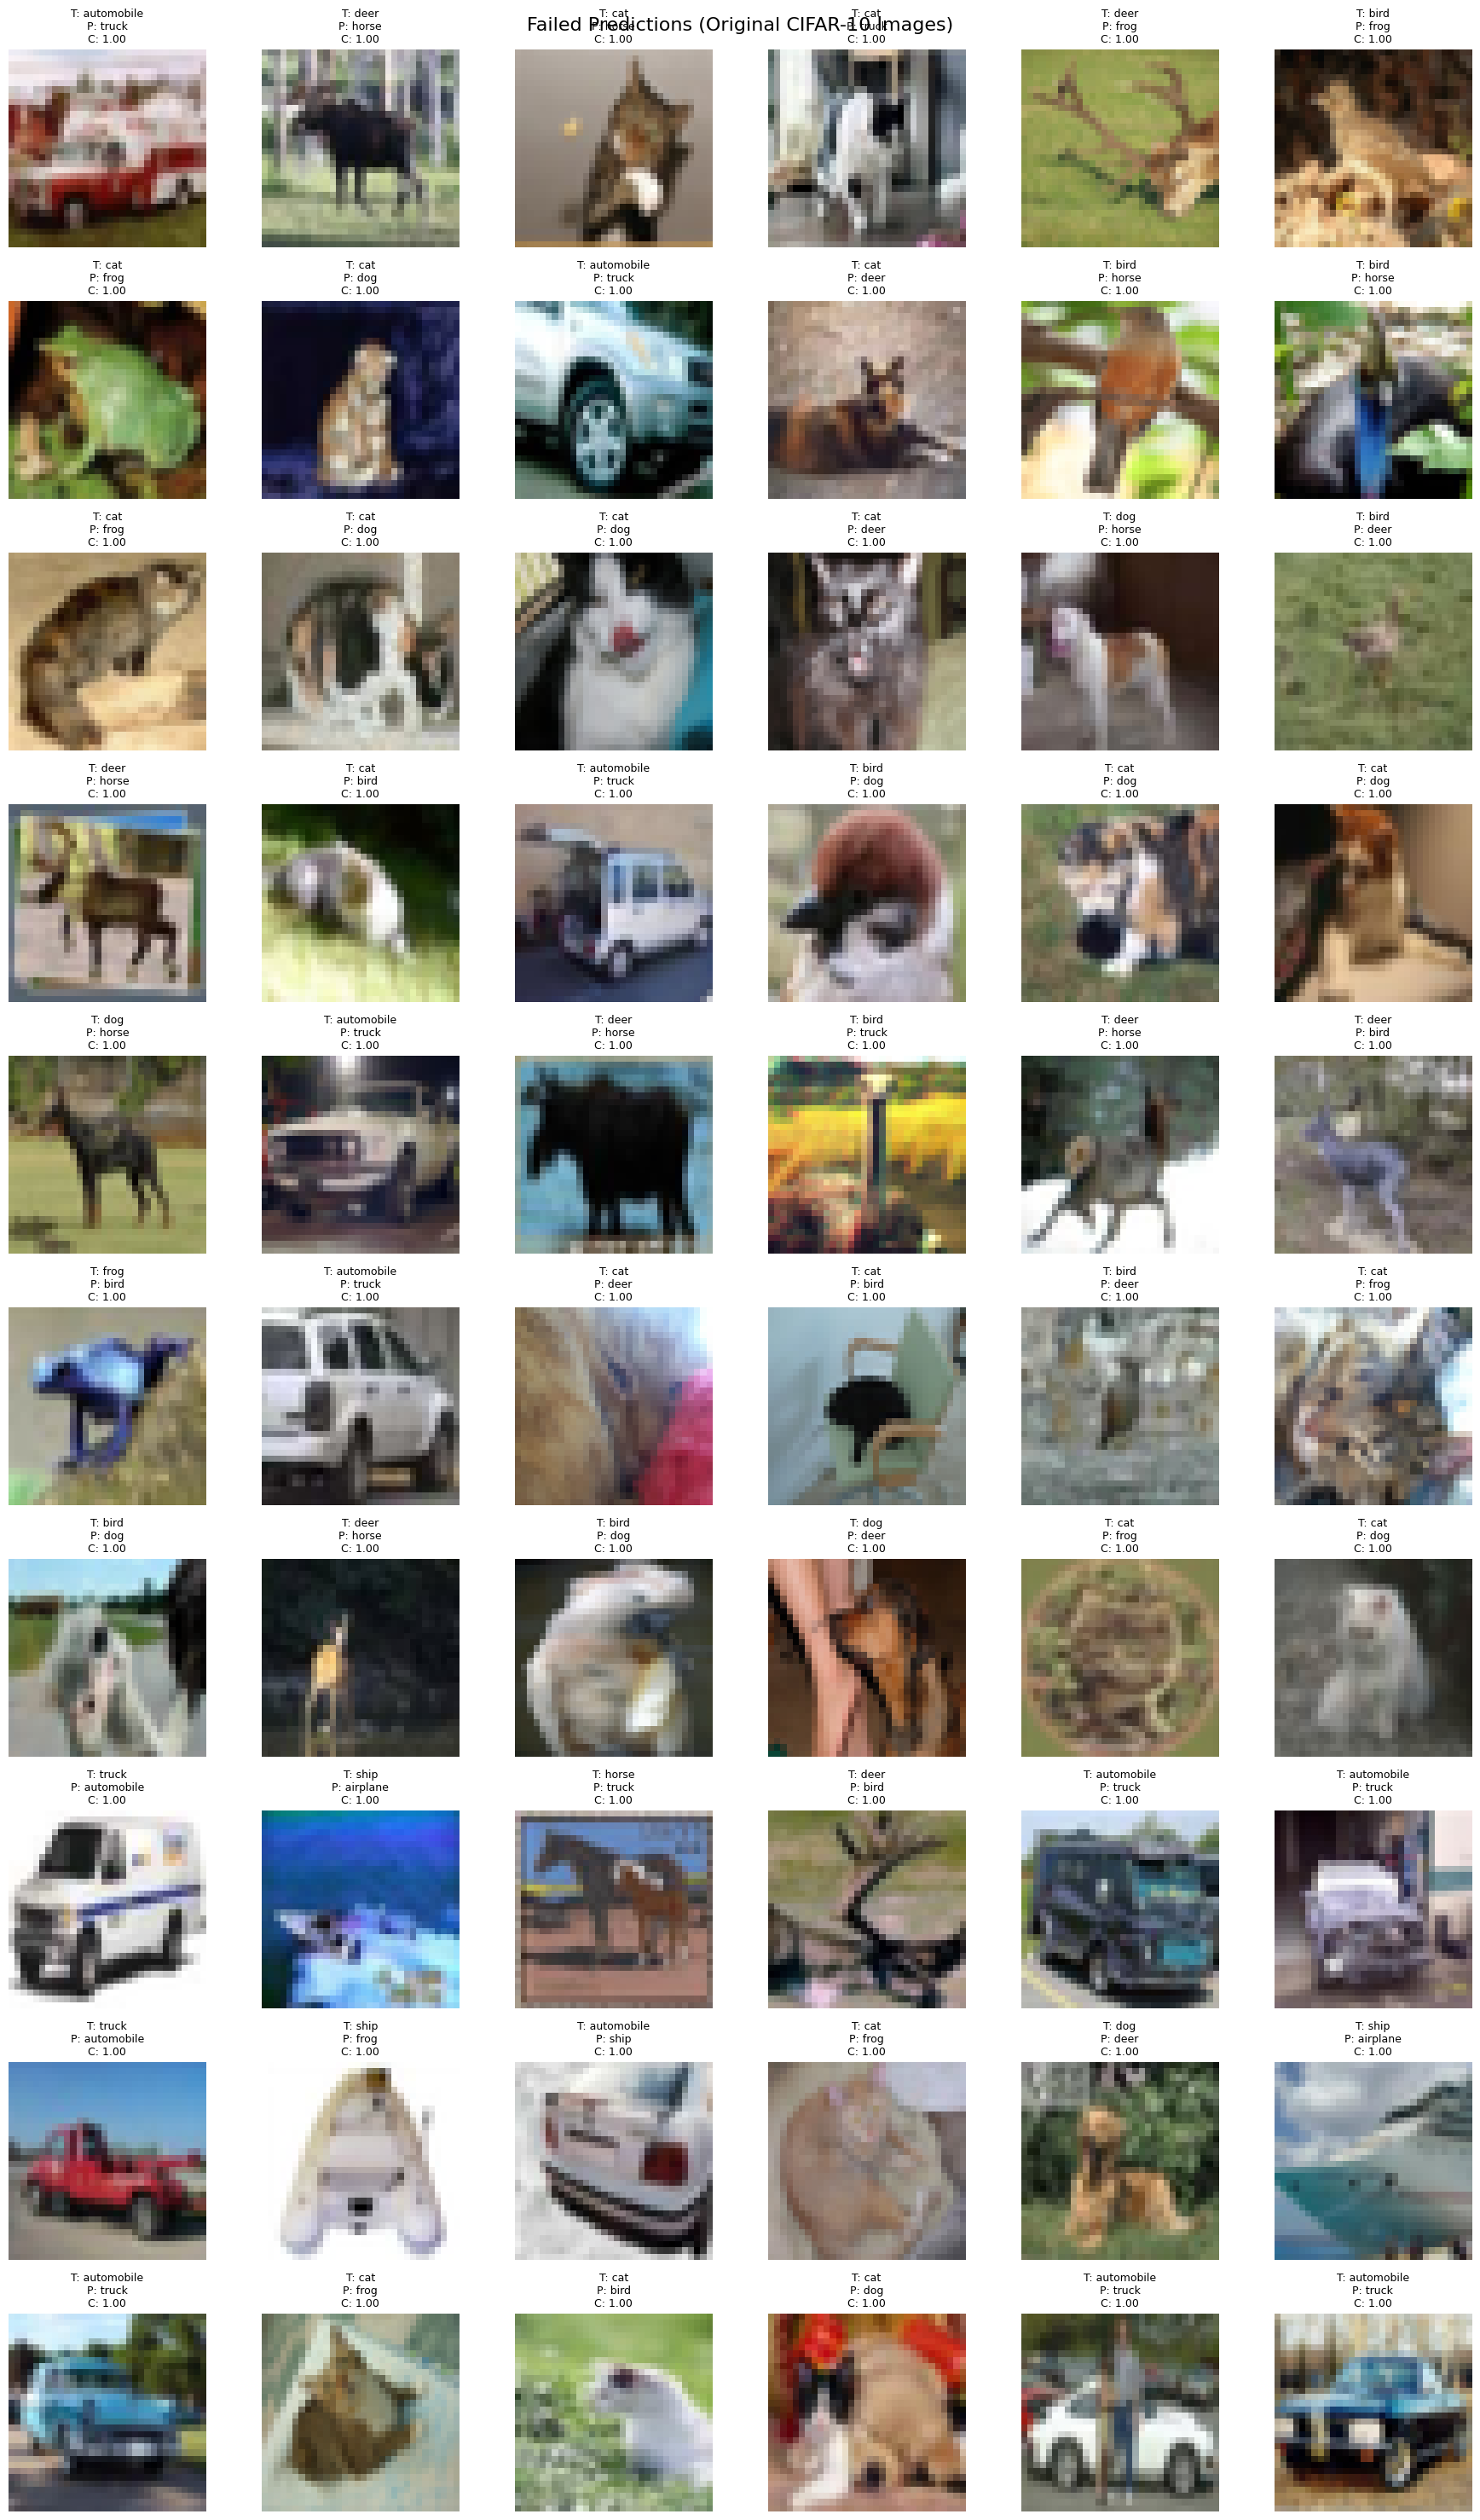

In [124]:
import matplotlib.pyplot as plt
import math

TOP_K = 60
num_images = min(TOP_K, len(failed_cases))

cols = 6
rows = math.ceil(num_images / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
axes = axes.reshape(rows, cols)

for idx in range(rows * cols):
    r, c = divmod(idx, cols)
    ax = axes[r, c]

    if idx < num_images:
        conf, data_idx, true_lbl, pred_lbl = failed_cases[idx]
        img, _ = raw_test_dataset[data_idx]

        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(
            f"T: {raw_test_dataset.classes[true_lbl]}\n"
            f"P: {raw_test_dataset.classes[pred_lbl]}\n"
            f"C: {conf:.2f}",
            fontsize=9
        )

    ax.axis("off")

plt.suptitle("Failed Predictions (Original CIFAR-10 Images)", fontsize=16)
plt.tight_layout()
plt.show()


# Modified-model training

# Modified-model Evaluation

# Performance Comparison